## Rosetta & Metropolis Monte Carlo

@Author: 吴炜坤

@email：weikun.wu@xtalpi.com weikunwu@163.com

在Rosetta中，蛋白质的构象采样使用的是梅特罗波利斯算法（Metropolis algorithm），Metropolis算法属于马尔可夫链蒙特卡罗算法的一种改进版本。本章节中，将从构象空间到马尔科夫链“细致平衡”的逐一进行介绍，尽可能以通俗易懂的方式来帮助同学们理解Metropolis算法。

### 一、构象空间与状态概率
蛋白质通常是一条(或多条)由N个氨基酸组成的多肽链，现在假定这个多肽都是由丙氨酸组成，因此只需要考虑它的主链二面角(2N-2个自由度)变化既能描述这个蛋白质的构象变化。此处为了方便可视化，只考虑2个丙氨酸组成的主链构象空间。此时刻画出来就是一张有边界的二维分布图(如下)。其中绿色的点代表不同骨架状态，这些所有可能存在的构象(微观态)就共同组成了这个多肽结构的构象空间(相空间)。

<center><img src="./img/conformation_space.jpg" width = "600" height = "200" align=center /></center>

研究蛋白质折叠最常用的一个热力学系统即恒温体系, 假设这个真空的系统中只有一个丙氨酸二肽分子。该体系中不同的状态(configuration)所具有的能量是不同的，某种状态在体系中出现的概率服从玻尔兹曼分布。即构象i出现的概率正比于玻尔兹曼因子(与能量有关):  $p_{i} \propto e^{-E_{i} / k T}$. 

如果某一构象能量低，则其在构象空间中出现的相对概率高，反之，一个构象的能量高，那么它出现的相对概率就低。同时体系温度也会影响构象出现概率，当温度升高时，高能量构象出现的概率升高，分子更容易进入高能状态。

一句话总结即: 恒定温度条件下，能量低的构象分子出现的相对概率高。溶液体系中能量相对低的构象比例占高。

<center><img src="./img/玻尔兹曼分布.jpg" width = "1000" height = "200" align=center /></center>

### 二、随机抽样

试想一下，目前我们获得了一条蛋白质的序列。目的是想获取它在某个温度条件下，构象空间中出现概率较大的那些构象集合(ensemble)。该怎么做呢？一个显而易见的方法是借鉴Monte Carlo随机抽样的思想，从构象空间中随机地**均匀地**抽取大量的构象状态，每一个构象都计算其能量(假设我们通过能量函数计算得到的构象能量是100%与真实能量吻合)。只要给定一个需要的能量阈值百分比。就可以获取到一批低能的构象集合。

具体操作:
1. 在一次独立的采样中，随机设定上述二肽分子的两个PHI/PSI二面角，得到一个独立的构象，并计算该构像能量;
2. 通过大量的重复独立的采样，得到许多的构象集合，截取构象能量前X%，统计拟合PHI/PSI二面角分布状态。


如下右图是总的采样情况(假设已经遍历)。再观察左图，我们通过10万次采样，取能量前1%的构象做统计，得到的分布图, 可以观测到其中有2个区间的构象富集，说明这个分布区间的主链能量比较低。

<center><img src="./img/mc_samping.jpg" width = "600" height = "200" align=center /></center>

看起来我们已经解决了蛋白质构象抽样的问题? 但是我们只考虑了2个二面角的构象空间。一般的蛋白质有100-1000个氨基酸，就算只考虑主链结构，至少也需要考虑2N-2个自由度。这将使得均匀地在构象空间中大量采样变得遥不可及。同时我们随机地采样，可能有90%以上的构象都是能量很高, 根据玻尔兹曼分布律，这些构象出现的概率极低，浪费了极大的计算资源。

那有没有一种方法可以高效地采集到的我们期望分布(比如玻尔兹曼分布)的构象数据呢？有的，那就是Metropolis Monte Carlo方法。

### 三、马尔科夫链

在开始Metropolis算法前，我们先了解下什么是马尔科夫链和平稳分布。

> 引自维基百科: 马尔可夫链为状态空间中经过从一个状态到另一个状态的转换的随机过程。该过程要求具备“无记忆”的性质：下一状态的概率分布只能由当前状态决定，在时间序列中它前面的事件均与之无关。这种特定类型的“无记忆性”称作马尔可夫性质。

<center><img src="./img/马尔科夫链.jpg" width = "600" height = "200" align=center /></center>

**重要性质: 在一阶的马尔科夫链，在当前构象中转移到其他构象的概率只由当前状态决定，与历史信息无关，并且其次经过足够多次的状态转移，最后各个状态的转移概率趋于平稳, 即平稳分布。**

简单类比，马尔科夫链中状态空间假设是有限的构象空间，每一个构象就是一个状态，假设目前有两个状态A和B分别是低/高能量构象状态，从A构象转变为B构象的概率为0.3(低能转高能构象概率低), 停留在A构象的概率为0.7(低能构象稳定), 从B构象转为A构象的概率为0.9(高能构象转为低能构象可能性高)，停留在B构象的概率为0.1(高能构象不稳定)。构建如此的马尔科夫链，可以用一个状态转移概率矩阵(如上右图)表示。矩阵的第一行代表在A状态转移到其他状态的概率(0.7+0.3=1.0), 类推，第二行代表从B状态转移到其他状态的概率。

接下来，我们举一个例子来说明如何使用马尔科夫链进行数据抽样:

In [36]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

dataframe = pd.DataFrame()

# 假设起始状态是低能:
t = np.array([1, 0])

count_A = 0
count_B = 0
# Sampling;
for i in range(1000):
    if t[0] == 1.0:  # 当前处于A构象
        p_a = 1 * 0.7 + 0*0.9
        p_b = 1 * 0.3 + 0*0.1
    else:            # 当前处于B构象
        p_a = 0 * 0.7 + 1*0.9
        p_b = 0 * 0.3 + 1*0.1

    # 判断;
    p = random.uniform(0, 1)
    if p < p_a:
        t = np.array([1, 0])
        dataframe.loc[i, 'State'] = 'A'
        count_A += 1
    else:
        t = np.array([0, 1])
        dataframe.loc[i, 'State'] = 'B'
        count_B += 1        

# 
total = count_A+count_B
print(count_A/total, count_B/total) # 统计比例;

0.753 0.247


从采样的状态轨迹来看，A状态占比较高，此处可见我们抽样的数据比例接近0.75:0.25, 先记住这个比例，**在思考下，多次运行上述代码，采样数据的分布比例近似0.75:0.25是偶然的么？**

我们再举一个例子说明马尔科夫链的平稳分布性质:<br>
假设我们在起始时间点(t0)的状态为高能状态，我们预测在下一个时间点t1, 可能状态概率分布是？根据转移矩阵定义，体系处于低/高能状态的概率(以向量表示)为s0=[0.9, 0.1]。那在t2时间点呢？处于低能状态的概率那就应该是0.9x0.7(从A停留到A)+0.1x0.9(从B转移到A)=0.72, 处于高能状态的概率即0.9x0.3(从A转移到B)+0.1x0.1(从B停留在B)=0.28, 即s1=[0.72, 0.28], 如此类推处于第20个时间点呢？

In [40]:
# t0状态概率分布.（这里可以尝试调整不同的概率分布试试！）
t0 = np.array([0.9, 0.1])

# 定义转移矩阵
P = np.array([[0.7,0.3],[0.9,0.1]])

# 如果迭代20次观察状态分布的变化:
dataframe = pd.DataFrame()
t = np.array([0.9, 0.1])
for i in range(20):
    dataframe.loc[i, 'time'] = i
    dataframe.loc[i, 'P_A'] = t[0]
    dataframe.loc[i, 'P_B'] = t[1]
    t = np.dot(t,P)
print(t)  # 最终的状态分布。

[0.75 0.25]


<AxesSubplot:xlabel='time', ylabel='P_A'>

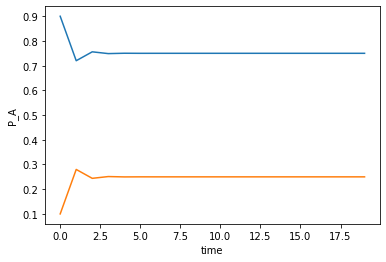

In [41]:
# 作图分布:
sns.lineplot(x="time", y="P_A", data=dataframe)
sns.lineplot(x="time", y="P_B", data=dataframe)

可见，通过前几次迭代，状态分布已经趋于平稳分布。并且马尔科夫链并不依赖于初始输入的构象，读者可以尝试使用不同的初始状态分布输入,重新运行代码观察现象。

**总之，一阶的马尔科夫链最终分布仅由转移概率矩阵P决定！换句话说，只要我们能找到对应的转移概率矩阵就能使得我们最后采集的数据满足某种分布状态**

### 四、细致平衡与Metropolis算法

在上述实验中，我们已经知道一阶的马尔科夫链分布经过足够次数的采样，轨迹中的数据必然收敛于某种分布情况，并且这个状态分布由概率转移矩阵P决定。回到蛋白质构象采样的问题上。已知某构象i的出现概率是正比于其玻尔兹曼因子, 即$p_{i} \propto e^{-E_{i} / k T}$。那应该如何构造这样一个矩阵使得我们采样的数据分布是符合玻尔兹曼分布的呢？

#### 1. 首先思考一个问题，体系下热平衡会发生什么现象？

热平衡体系下构象出现的概率是稳定的，用公式写出即如下，**$\pi_{i}$为某一构象出现的概率，$P_{i->j}$为构象转移的概率**:

$$
\pi_{i} P_{i->j} = \pi_{j} P_{j->i}
$$

$$
\sum_{i} \pi_{i} P_{i->j} = \sum_{j} \pi_{j} P_{j->i}
$$

**表明一个构象向其他构象转变的概率等于从其他所有构象转移至当前构象的概率**，同时也表明一个构象向其他构象转变的概率之和等于从其他所有构象转移至当前构象的概率之和。这个条件被称为细致平衡，即微观可逆性。试想下如果不满足该条件，即构象流出率大于流入率，那么体系中的构象出现概率将发生偏倚，不再处于初始状态分布，平衡被打破，这是符合我们朴素的认知的。

此概念在马尔科夫链中同样适用，**换言之，如果一个状态的概率分布满足了细致平衡，必然已经得到了平稳分布。** <br>
现在证明一下这个条件充分性，证式:<br>

$$
\sum_{i} \pi_{i} P_{i->j}=\sum_{i} \pi_{j} P_{j->i}=\pi_{j} \sum_{i} P_{j->i}=\pi_{j}
$$

设现已满足细致平衡，即$\pi_{i} P_{i->j} = \pi_{j} P_{j->i}$，必然满足$\sum_{i} \pi_{i} P_{i->j}=\sum_{i} \pi_{j} P_{j->i}$, 右式中，$\pi_{j}$与i无关可以提出来，又因从j状态转移到所有其他的i状态的概率和必须等于1，而满足$\sum_{i} P_{j->i}=1$，所以$\pi_{j} \sum_{i} P_{j->i}=\pi_{j}$。说明从所有的状态i转移到j的概率之和等于状态j自身出现的概率，构象概率的净流入为0，即达到平稳分布。

#### 2. 现在思考另一个问题，如何让平稳分布服从玻尔兹曼分布？

此处讨论的是构象分布，因此我们希望采样得到的数据中，状态概率分布($\pi_{1}..\pi_{i}.. \pi_{j})$服从玻尔兹曼分布，在马尔科夫链的采样中，如果满足细致平衡，即:

$$
\frac{\mathrm{P_{i->j}}}{\mathrm{P_{j->i}}}=\frac{\mathrm{\pi_{j}}}{\mathrm{\pi_{i}}} = \frac{\exp \left(-\frac{E_{j}}{k T}\right)}{\exp \left(-\frac{E_{i}}{k T}\right)}=\exp \left(-\frac{\Delta{E}}{k T}\right)
$$


从上述的表达式可以更加清晰的看到，如果需要$\pi_{j}, \pi_{i}$满足某种分布关系，将他们相除就可以得到两个状态之间的转移概率关系，但目前依然没有很好的办法直接把P矩阵的具体形式写出来。<br>

由于一般情况下，目标平稳分布($\pi_{1}..\pi_{i}.. \pi_{j})$ 和**任意一个马尔科夫链状态转移矩阵𝑄不满足细致平稳条件**，即:
$$
\pi_{i} Q_{i->j} \neq \pi_{j} Q_{j->i}
$$

一个常见的解决办法就是，选择一个Q矩阵作为基础转移矩阵(一般是高斯或则均匀，这样比较好采样)，然后再对上述的公式做矫正处理。
Metropolis的方法是引入一个接受概率$\alpha(i,j)$(取值在0~1区间)代表从i构象转移到j构象的接受概率, 使细致平稳条件成立, 使上式可以取等号:

$$
\pi_{i} Q_{i->j} \alpha(i, j)=\pi(j) Q_{j->i} \alpha(j, i)
$$

对应的马尔科夫链状态转移矩阵P，满足:
$$
P_{i->j}=Q_{i->j} \alpha(i, j)
$$
$$
\alpha(i, j)=\pi_{j} Q_{j->i}
$$
$$
\alpha(j, i)=\pi_{i} Q_{i->j}
$$

为了让采样时接受的概率更大, Hastings做了改进，起让$\alpha(i,j), \alpha(j,i)$等倍增加，直到$\alpha(j,i)=1$, 此时公式可以更加简化:

$$
\alpha(i, j)=\frac{\pi_{j} Q_{j->i}}{\pi_{i} Q_{i->j}}
$$
$$
\alpha(j, i)= 1
$$

此时马尔科夫链中的构象转移概率可表示为:<br><br>
$$
\begin{aligned} \mathrm{P_{i->j}} = Q_{j->i}*\exp \left(-\frac{E_{j}-E_{i}}{k T}\right) &\left(\Delta{E}>0\right)
\\
\mathrm{P_{i->j}} = 1*Q_{j->i} &\left(\Delta{E}   \leq 0\right) \end{aligned}
$$

**当我们选择的马尔科夫链状态转移矩阵𝑄如果是对称的, 即 $Q_{i->j}=Q_{j->i}$，构象是否被接受只和$\alpha(i,j)$有关**。 <br>
此处易证, 当$\Delta{E}>0$时, 即新的构象j能量更高时:

$$
\frac{\mathrm{P_{i->j}}}{\mathrm{P_{j->i}}}
=\frac{\alpha(i,j)}{1}
=\frac{\exp \left(-\frac{E_{j}-E_{i}}{k T}\right)}{1}
={\exp \left(-\frac{E_{j}-E_{i}}{k T}\right)}
$$

当$\Delta{E}<=0$时, 即新的构象j能量更低时:

$$
\frac{\mathrm{P_{i->j}}}{\mathrm{P_{j->i}}}
=\frac{1}{\alpha(j,i)}
=\frac{1}{exp \left(-\frac{E_{i}-E_{j}}{k T}\right)}
={\exp \left(-\frac{E_{j}-E_{i}}{k T}\right)}
$$

因此可以直接从接受率上直观感受Metropolis的过程，当$\Delta{E}>0$时，从i构象转移到j构象的概率是必然是小于1的，以一定的概率(比例)接受高能构象。能量差越大，转移到高能构象的概率越低，如果不受限地转移，那必然破坏现有的分布情况。当$\Delta{E}<=0$时，以100%的概率转移到新的低能构象。并且$\Delta{E}$的取值如何，构建的转移概率P都满足细致平衡的条件并服从玻尔兹曼分布。

#### 3. Metropolis算法的实现步骤

具体的Metropolis算法步骤如下:
- 首先初始化一个构象i, 如初始化骨架的二面角;
- 根据基础转移矩阵Q进行构象采样，得到新的构象j. 并计算能量差$\Delta{E}$;
- 进行构象接受判断:
    - 如果$\Delta{E}<=0$, $P_{accept}=1$, 直接接受新的低能量构象.
    - 如果$\Delta{E}>0$, $P_{accept}=\exp \left(-\frac{\Delta{E}}{k T}\right)$, 在[0-1]区间范围内生成随机数u. 如果$u < P_{accept}$接受高能构型，反之拒绝。

<center><img src="./img/Metropolis.jpg" width = "800" height = "200" align=center /></center>

接着此处我们尝试使用Metropolis来进行重要性抽样(10000步, 不做能量截取)，共3条轨迹，可以对比一下与此前进行随机抽样的效果。可见使用mcmc的效率更高，可以直接探索低能量区域的范围，重点采样了那些能量较低的构象。<br>
<center><img src="./img/mcmc.jpg" width = "900" height = "200" align=center /></center>
相关代码储存在本章节文件夹中的mcmc.py中。

### 五、模拟退火与最优化

在第一节的部分，我们提到过构象i出现的概率正比于玻尔兹曼因子(与能量有关):  $p_{i} \propto e^{-E_{i} / k T}$。那也就意味着温度对Metropolis方法的采样有较大的影响。此处，我们使用不同温度条件进行mcmc轨迹生成，看看有些什么影响。

<center><img src="./img/SA.jpg" width = "900" height = "200" align=center /></center>

从模拟的结果来看，随着kT的温度下降，构象采样的范围不断缩小。这是因为在Metropolis中下一步构象的接受率$ \alpha(i,j) \propto {\exp \left(-\frac{E_{j}-E_{i}}{k T}\right)}$，当温度上升时，接受率增加，此时构象很容易跳出局部能量的鞍点。当温度下降时，高能构象接受率下降，构象被困在能量的局部最小值区域。这就是由Kirkpatrick等人以Metropolis的方法为基础发展出来的模拟退火算法(将温度变量引入其中)，目的是求NP-hard问题中的最优解方案。

模拟退火算法中，先设定一个较高的温度(Rosetta中一般kT设置为2.0)，执行一定循环次数的Metropolis算法探索构象，然后记录下能量最低的构像，以此作为输入，并降低kT值后，再执行一定循环次数的Metropolis算法。以此往复，直到达到目标温度(kT=0.5)。在模拟退火算法执行期间，随着温度参数减小，算法返回某个整体最优解的概率单调增加，返回某个非最优解的概率单调减少；在足够多的扰动及迭代次数下，渐近收敛于近似最优解集。这也就是为何在Rosetta中，一个Protocol常常需要大量资源去生成许多轨迹的原因。

在Rosetta中，模拟退火的内循环中(同一温度条件下)，Metropolis算法通常与Minimization连用一同，更有效率地去找全局能量的低点。**可以思考下，模拟退火过程中，所有采集的构象还满足玻尔兹曼分布么？**<br>

<center><img src="./img/mcmc_min.jpg" width = "900" height = "200" align=center /></center>

#### 课后习题: 
1. 尝试利用丙氨基酸二肽作为初始结构，使用Metropolis+Minimization进行构象搜索，观察所得到的的构象分布情况是否有变化？
2. 使用模拟退火的方法进行构象搜索，观察所得到的的构象分布情况是否有变化？